In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context# this is for me 


In [2]:
import torch
import torchvision 
import torch.nn as nn
from torchvision import transforms , datasets
from torch.utils.data import DataLoader

In [3]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

In [4]:
from pathlib import Path
train_dataset = torchvision.datasets.MNIST(root=Path('./data')
                                           ,train=True,
                                           transform=transform,
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root=Path('./data')
                                           ,train=False,
                                           transform=transform,
                                           download=True)

In [5]:
import os
BATCH_SIZE=64
NUM_WORKERS=os.cpu_count()
train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)
class_names = train_dataset.classes

In [6]:
train_dataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [7]:
images , labels=next(iter(test_dataloader))

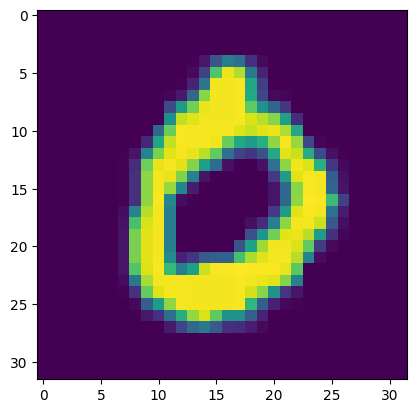

In [8]:
import matplotlib.pyplot as plt 
plt.imshow(images[3].permute(1,2,0))


In [9]:
class VanillaAutoencoder(nn.Module):
    def __init__(self):
        super(VanillaAutoencoder, self).__init__()
        # Encoder: compress input
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        # Decoder: reconstruct input
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 32),
            nn.Sigmoid()  # keep output in [0,1]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input image
        encoded = self.encoder(x)  # Encode input
        decoded = self.decoder(encoded)  # Decode latent vector
        decoded = decoded.view(x.size(0), 1, 32, 32)  # Reshape to image
        return decoded
model = VanillaAutoencoder()        

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.001, params = model.parameters())

In [38]:
epochs = 5
from tqdm.auto import tqdm
for epoch in tqdm(range(epochs)):
    for batch , (X,y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred ,X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"{epoch}_epoch {loss:0.4}_loss")    
    

  0%|          | 0/5 [00:00<?, ?it/s]

0_epoch 0.01009_loss
1_epoch 0.009168_loss
2_epoch 0.00852_loss
3_epoch 0.008192_loss
4_epoch 0.007927_loss


In [11]:
images , _ = next(iter(test_dataloader))

In [12]:
pred_img = model(images[0])
pred_img.squeeze(dim=1).shape
type(pred_img.squeeze(dim=1))

torch.Tensor

In [13]:
images[0].unsqueeze(0).shape


torch.Size([1, 1, 32, 32])

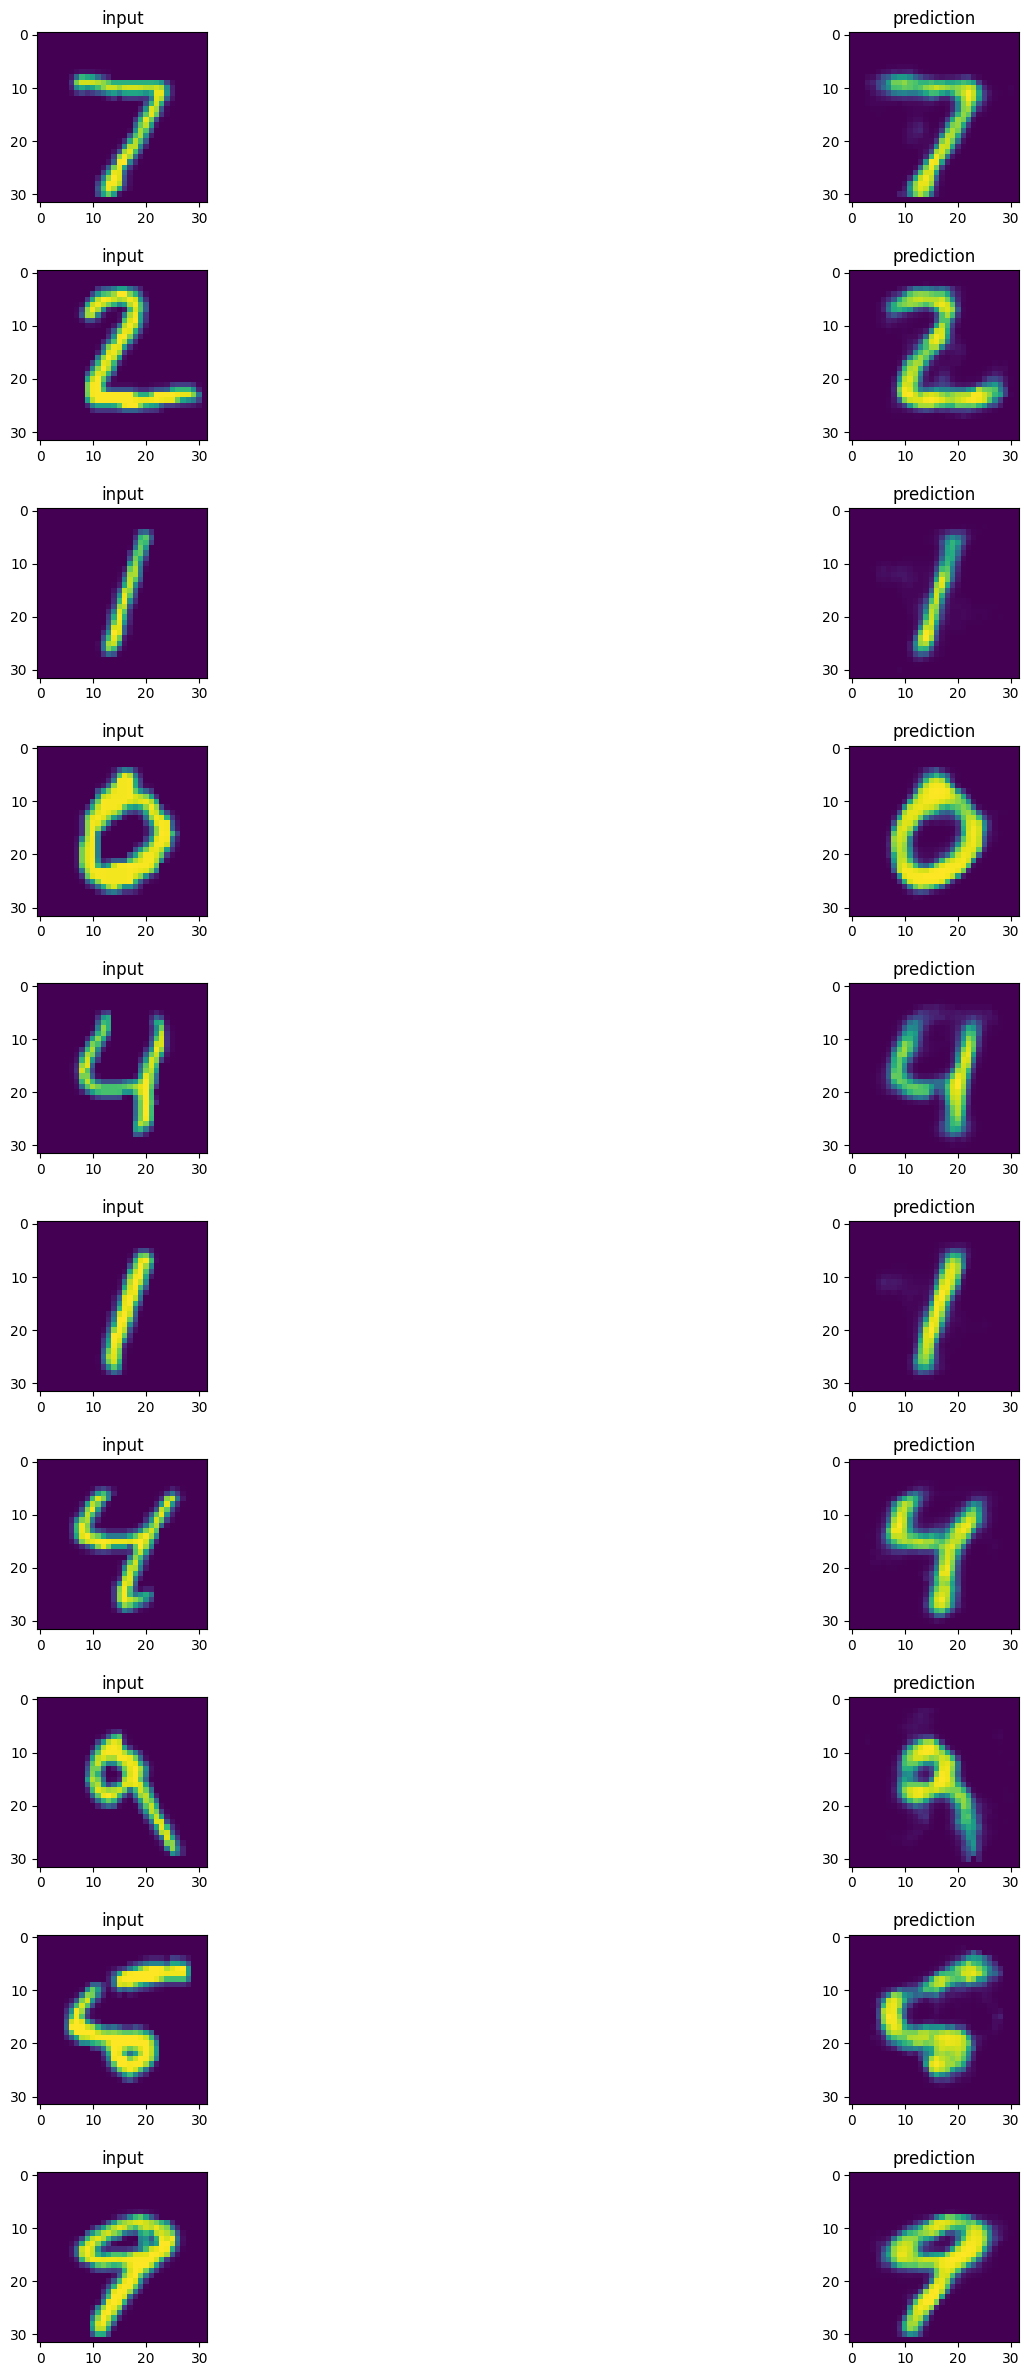

In [39]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 30))
fig.subplots_adjust(hspace=0.4, wspace=.1)
for i in range(10):
    axes[i,0].imshow(images[i].permute(1,2,0))
    axes[i,0].set_title('input')
   
    with torch.no_grad():
        pred_img = model(images[i].unsqueeze(0))
    axes[i,1].imshow(pred_img.squeeze(dim=1).permute(1,2,0))
    axes[i,1].set_title('prediction')

In [79]:
# ok let's use that to encoder on our dataset  
x = images[0].unsqueeze(0)          # shape -> (1, 32, 32)
x_flat = x.view(x.size(0), 1024)      # shape -> (1, 1024)
encoded = model.encoder(x_flat)
encoded.element_size() *encoded.nelement()

128

In [80]:
decoded = model.decoder(laten_vector)
decoded = decoded.view(1,32,32)
decoded.element_size() *decoded.nelement()

4096

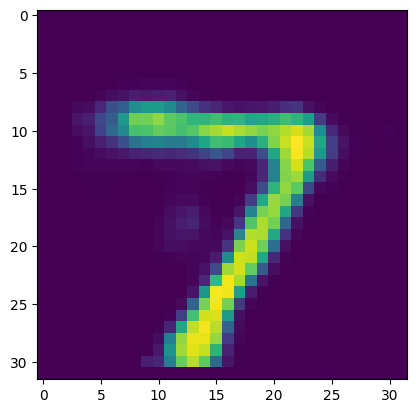

In [73]:
plt.imshow(decoded.detach().permute(1,2,0))

In [102]:
x=0
for data , _ in test_dataloader:
    x=x+(data.element_size()*data.nelement())
x

40960000

In [101]:
encoded_data = []
model.eval()  
with torch.no_grad():  
    for data, _ in test_dataloader:
        data = data.view(data.size(0), -1)
        #print(data.shape)
        encoded = model.encoder(data)
        encoded_data.append(encoded)
x=0
for i in range(len(encoded_data)):
    x=x+(encoded_data[i].element_size()*encoded_data[i].nelement())
x            

1280000

1280000